# Patch clamp analysis

## sEPSC demo trace

In [1]:
import pyabf

In [2]:
import os.path
import os

In [3]:
def getAllFiles(rootDir):
    FilePath=[]
    Files=[]
    for (root, sub, file) in os.walk(rootDir):
        if not(sub):
            FilePath+=[os.path.join(root, f) for f in file]
            Files+=[f.split('.')[0] for f in file]
    return(FilePath,Files)

In [4]:
mFiles,_=getAllFiles("../../mini EPSC/")

### representative trace

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

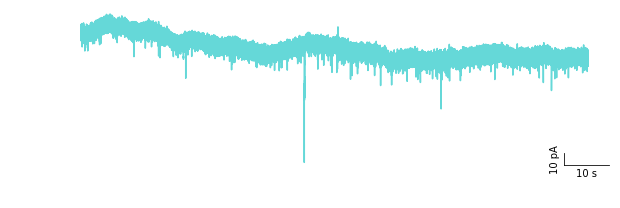

In [6]:
mDemo=pyabf.ABF(mFiles[0])

plt.figure(figsize=(10,3))
plt.plot(mDemo.sweepX, mDemo.sweepY, color='c', alpha=.6)
plt.ylabel(mDemo.sweepLabelY)
plt.xlabel(mDemo.sweepLabelX)
plt.axis('off')

ax=plt.gca()
axin=zoomed_inset_axes(ax, 10, 4, axes_kwargs={'xlabel':'10 s','ylabel':'10 pA','xticks':[],
                                              'yticks':[]})
axin.spines['top'].set_visible(False)
axin.spines['right'].set_visible(False)

plt.show()

### average trace

In [7]:
import pandas as pd
import numpy as np

In [8]:
mDemoTrace=pd.read_csv('../../process/mEPSC_trace/19315000.txt',
                       skiprows=6,sep='\t',header=None)

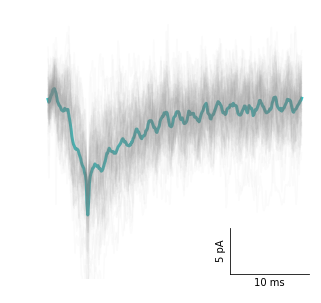

In [9]:
plt.figure(figsize=(5,5))
plt.plot(mDemoTrace[0],mDemoTrace[1], 'c-', linewidth=3, alpha=.8)
plt.plot(mDemoTrace[0],mDemoTrace.iloc[:,2:], color='grey' ,alpha=.03)

plt.axis('off')
plt.ylim(bottom=-20)

ax=plt.gca()
axin=zoomed_inset_axes(ax,10,4,axes_kwargs={'xlabel':'10 ms','ylabel':'5 pA',
                                            'xticks':[],'yticks':[],'ylim':(0,.5)})
axin.spines['top'].set_visible(False)
axin.spines['right'].set_visible(False)

plt.show()

## cumulative distribution

In [10]:
itiFiles,_=getAllFiles('../../process/mEPSC_interEvent/')
ampFiles,_=getAllFiles('../../process/mEPSC_amplitude_data/')

In [11]:
itiDemoFile=itiFiles[0]
ampDemoFile=ampFiles[0]

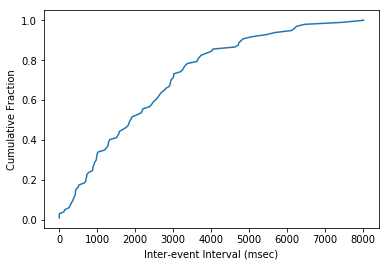

In [12]:
itiDemoData=pd.read_csv(itiDemoFile,skiprows=3,sep='\t')
plt.plot(itiDemoData['Inter-event Interval (msec)'],itiDemoData['Cumulative Fraction'])
plt.xlabel('Inter-event Interval (msec)')
plt.ylabel('Cumulative Fraction')
plt.show()

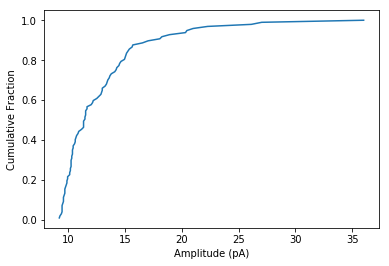

In [13]:
ampDemoData=pd.read_csv(ampDemoFile,skiprows=3,sep='\t')
plt.plot(ampDemoData['Amplitude (pA)'],ampDemoData['Cumulative Fraction'])
plt.xlabel('Amplitude (pA)')
plt.ylabel('Cumulative Fraction')
plt.show()

## AP demo trace

### raw trace

In [14]:
apFiles=[]
for root,subDir,file in os.walk('../../AP/'):
    if not(subDir):
        apFiles+=[os.path.join(root, f) for f in file]

In [15]:
apDemoFile='../../AP/20190408/cell 2/19408000.abf'
apDemoAbf=pyabf.ABF(apDemoFile)

In [16]:
import pyabf.plot

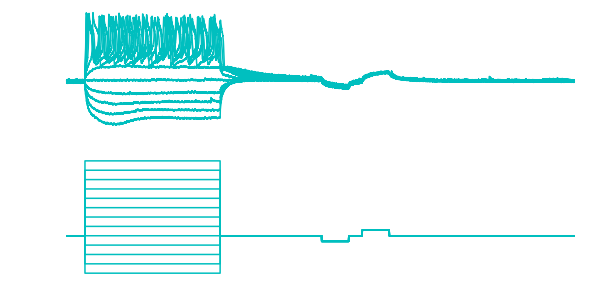

In [17]:
fig = plt.figure(figsize=(10,5))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)
for sweep in apDemoAbf.sweepList:
    apDemoAbf.setSweep(sweep)
    ax1.plot(apDemoAbf.sweepX, apDemoAbf.sweepY, 'c')
    ax2.plot(apDemoAbf.sweepX, apDemoAbf.sweepC, 'c')
ax1.axis('off')
ax2.axis('off')

plt.show()

### AP distribution

In [18]:
fitFiles,_=getAllFiles('../../process/AP_fit/')

demofitFile='../../process/AP_fit/demo.csv'
fitFiles.remove(demofitFile)

fitDemoFile=fitFiles[0]

In [19]:
def readTitle(demoFile):
    with open(demoFile,'r') as f:
        title=f.readline().split(',')
    for ind,txt in enumerate(title):
        if txt=='' or txt=='\n':
            title[ind]='col_'+str(ind+1)
    return(title)

In [20]:
title=readTitle(demofitFile)
def readFitFile(file, head):
    fitDemoData=pd.read_csv(file,sep='\t',names=head)
    new=fitDemoData['Identifier'].str.extract('(?P<filename>.*abf) G(?P<sweep>\d+) T (?P<AP_ID>\d+) AP')
    rlt=pd.concat([new,fitDemoData.drop('Identifier',axis=1)],axis=1)
    rlt[['sweep','AP_ID']]=rlt[['sweep','AP_ID']].astype('int64')
    return(rlt)
fitDemoData=readFitFile(fitDemoFile,title)

### AP frequency

In [21]:
apFreqRoot='../../process/AP_freq_data/'
apFreqFiles,_=getAllFiles(apFreqRoot)
apFreqDemoFile=apFreqFiles[0]

In [22]:
def getCellID(filePath):
    return(os.path.split(filePath))[-1].split('.')[0]

In [23]:
def readOneAPfreqData(filepath):
    dt=pd.read_csv(filepath,sep='\t',skiprows=1)
    dt.dropna(how='all',inplace=True)
    dt.rename({'Unnamed: 0':'sweep'},axis=1,inplace=True)
    dt.sweep=dt.sweep.str.extract('Group # (\d+)').astype('int64')
    dt.n=dt.n.astype('int64')
    dt['CellID']=getCellID(filepath)
    dt=dt[np.roll(dt.columns,1)]
    return(dt)

In [24]:
apFreqDemoData=readOneAPfreqData(apFreqDemoFile)

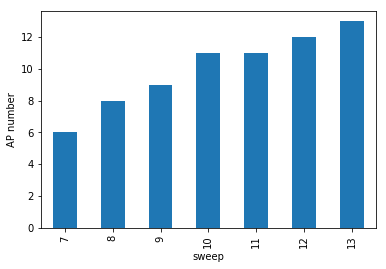

In [25]:
fig=apFreqDemoData.plot('sweep','n',kind='bar',legend=False)
plt.ylabel('AP number')
plt.show()

In [26]:
apAllFreqData=pd.concat(map(readOneAPfreqData,apFreqFiles))

### AP amplitude

In [27]:
apAmpRoot='../../process/AP_amplitude_data/'
apAmpFiles,_=getAllFiles(apAmpRoot)
apAmpDemoFile=apAmpFiles[0]
apAmpDemoData=readOneAPfreqData(apAmpDemoFile)

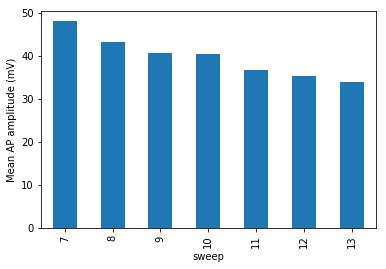

In [28]:
apAmpDemoData.plot('sweep','Average',kind='bar',legend=False)
plt.ylabel('Mean AP amplitude (mV)')
plt.show()

## I/V relationship

### plot I-V traces

In [29]:
ivFileDemo='../../process/IV_data/19408008.atf'

In [30]:
import numpy as np
import re

In [31]:
def readAtfText(filename):
    with open(filename, 'r') as f:
        txt=f.readlines()
    title=re.findall(r'"([^"]*)"',txt[2])
    datastr=txt[3].split('\t')
    sz=(len(datastr)//len(title), len(title))
    dt=pd.DataFrame(np.array(datastr).reshape(sz), columns=title)
    return(dt)

In [32]:
ivDemo=readAtfText(ivFileDemo)
ivDemo.iloc[:,[1,2,6,7,8,9]]=ivDemo.iloc[:,[1,2,6,7,8,9]].apply(pd.to_numeric)

In [33]:
def get_APCurrentStep(filename):
    apDemoAbf=pyabf.ABF(filename)
    cur_step=[]
    for sweep in apDemoAbf.sweepList:
        apDemoAbf.setSweep(sweep)
        cur_step.append(apDemoAbf.sweepEpochs.levels[2])
    return(cur_step)

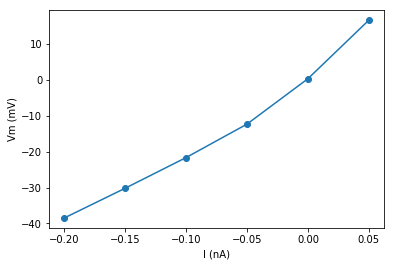

In [34]:
plt.plot(get_APCurrentStep(apDemoFile)[:6],ivDemo['S1R1 Mean (mV)'],'-o')
plt.xlabel('I (nA)')
plt.ylabel('Vm (mV)')
plt.show()

In [35]:
apFilePath,apFiles=getAllFiles("../../AP/")

In [36]:
def IVfileMatchABF(ivFile):
    return apFilePath[getCellID(ivFile)==apFiles]

In [37]:
ivFiles,apCellIDs=getAllFiles('../../process/IV_data/')

In [38]:
def getOneIVdata(filePath):
    ivRead=readAtfText(filePath)
    apFile=IVfileMatchABF(filePath)
    sweepNum=ivRead.shape[0]
    curStep=get_APCurrentStep(apFile)[:sweepNum]
    dt=pd.DataFrame({'CellID':getCellID(filePath),'I':curStep,
                     'Vm':ivRead['S1R1 Mean (mV)']})
    dt.I=pd.to_numeric(dt.I)
    dt.Vm=pd.to_numeric(dt.Vm)
    return(dt)

In [39]:
getOneIVdata(ivFileDemo)

,CellID,I,Vm
0,19408008,-0.20,-38.45260
1,19408008,-0.15,-30.16080
2,19408008,-0.10,-21.61450
3,19408008,-0.05,-12.29580
4,19408008,0.00,0.34833
5,19408008,0.05,16.65140


In [40]:
ivAllData=pd.concat(map(getOneIVdata, ivFiles),ignore_index=True)

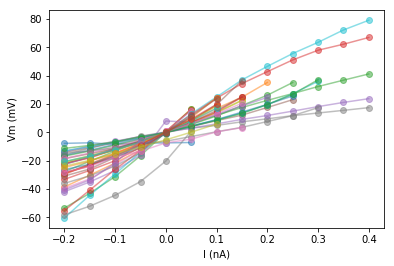

In [41]:
for key,tb in ivAllData.groupby('CellID'):
    plt.plot(tb['I'],tb['Vm'],'-o',alpha=.5)
plt.xlabel('I (nA)')
plt.ylabel('Vm (mV)')
plt.show()

### Compute membrane resistance

In [42]:
ivDemoDt=getOneIVdata(ivFileDemo)

In [43]:
from sklearn.linear_model import LinearRegression

In [44]:
x=ivDemoDt[['I']]
y=ivDemoDt['Vm']
reg=LinearRegression().fit(x,y)

In [45]:
reg.score(x,y)

0.9799562806194935

In [46]:
reg.coef_

array([215.0663])

In [47]:
reg.intercept_

1.8759802857142898

In [48]:
reg.predict(x)

array([-41.1373, -30.384 , -19.6307,  -8.8773,   1.876 ,  12.6293])

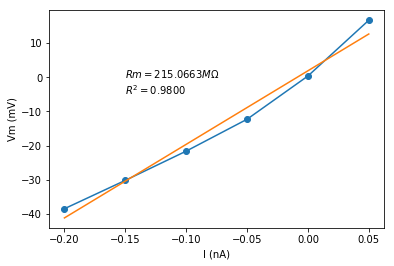

In [49]:
plt.plot(x.values,y,'-o',x.values,reg.predict(x),'-')
plt.xlabel('I (nA)')
plt.ylabel('Vm (mV)')
plt.text(-0.15,0,r'$Rm=%.4f M\Omega$' % reg.coef_)
plt.text(-0.15,-5,r'$R^2=%.4f$' % reg.score(x,y))
plt.show()

In [50]:
def computeRm(IVdata):
    x=IVdata[['I']]
    y=IVdata['Vm']
    reg=LinearRegression().fit(x,y)
    score=reg.score(x,y)
    coef=reg.coef_[0]
    return {'Rm':coef,'R_score':score}

In [51]:
computeRm(ivDemoDt)

{'Rm': 215.0663339381191, 'R_score': 0.9799562806194935}

In [52]:
res=ivAllData.groupby('CellID').apply(computeRm)
RmRes=pd.DataFrame(res.to_list(),index=res.index).reset_index()

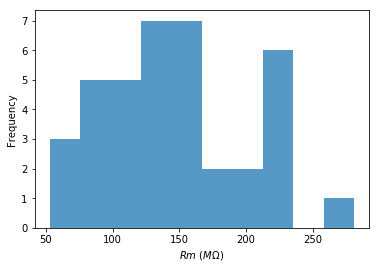

In [53]:
RmRes[RmRes.R_score>0.9].Rm.plot.hist(alpha=.75)
plt.xlabel(r'$Rm\ (M\Omega)$')
plt.show()

## relationship of intrinsic membrane properties

# Morphological analysis

In [54]:
import metakernel

In [66]:
metakernel.register_ipython_magics()
%kernel matlab_kernel.kernel MatlabKernel

In [67]:
%%kx
addpath('../../../reconstruction/traces/')
addpath('../../../reconstruction/functions/')
addpath(genpath('/usr/local/matlab2017b/toolbox/shared/TREES1.15/'),'-end') # trees toolbox

In [68]:
%%kx
load morpho_data.mat

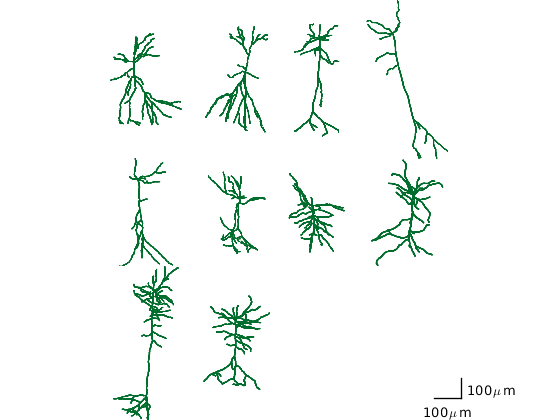

In [69]:
%%kx
plot_multi_tree(tr,treeColor,[3 floor(size(tr,2)/3+1)]);
draw_scale_bar(100,'xy');

Put apical dendrites upside:

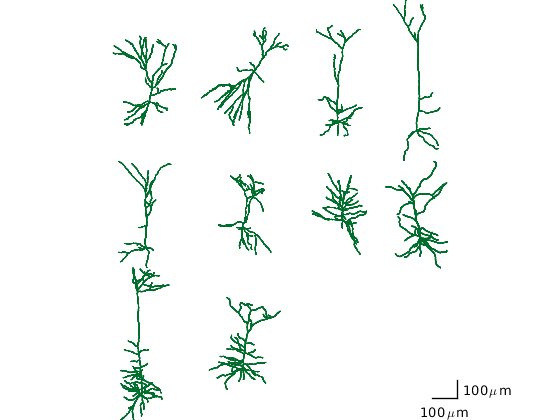

In [70]:
%%kx
for n=1:size(tr,2)
    trUpsided(n)=apical_upside(tr(n));
end
plot_multi_tree(trUpsided,treeColor,[3 floor(size(trUpsided,2)/3+1)]);
draw_scale_bar(100,'xy');

## Sholl analysis

Analyse by Matlab:

In [60]:
import matlab.engine
eng=matlab.engine.start_matlab()

In [ ]:
%%kx

Analyse by morphological data exported by Imaris:

In [122]:
allShollStatFile,_=getAllFiles('../../../reconstruction/stat/')
statFiles,somaStatFiles=[],[]
for f in allShollStatFile:
    if 'soma' in f:
        somaStatFiles.append(f)
    else:
        statFiles.append(f)

In [209]:
def readOneMorphoData(file):
    tb=pd.read_csv(file,skiprows=2,header=1)
    tb['neuron_ID']=os.path.split(file)[-1].split('_Detailed.')[0]
    return(tb[np.roll(tb.columns,1)])

In [210]:
morphoData=pd.concat(map(readOneMorphoData,statFiles))

/home/memory_fzq/anaconda3/envs/clamp/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [212]:
shollData=morphoData[morphoData.Variable=='Filament No. Sholl Intersections'].loc[:,['neuron_ID','Radius','Value']]

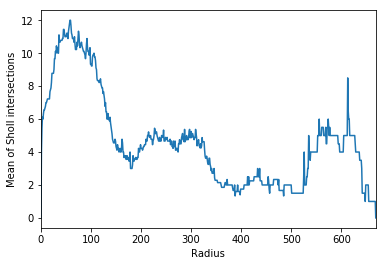

In [328]:
shollData.groupby('Radius').mean().reset_index().plot('Radius','Value',legend=False)
plt.ylabel('Mean of Sholl intersections')
plt.show()

## angle distribution

## branch order

In [319]:
depthData=(morphoData[morphoData.Variable=='Dendrite Branch Depth']
           .loc[:,['neuron_ID','Depth','Level','Value']]
           .groupby(['neuron_ID','Depth']).count().reset_index()
           .drop('Level',axis=1).rename({'Value':'counts'},axis=1))
depthData.Depth=depthData.Depth.astype('int64')

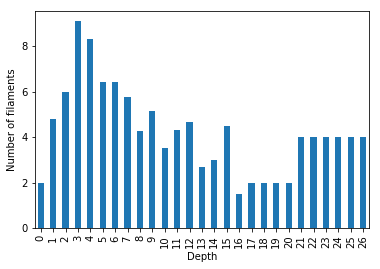

In [327]:
depthData.groupby('Depth').mean().reset_index().plot.bar('Depth','counts',legend=False)
plt.ylabel('Number of filaments')
plt.show()